In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from collections import deque
import tensorflow as tf
from tqdm import tqdm 
from tensorflow.keras import Sequential 
from tensorflow.keras.activations import relu, linear
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop
import math
from random import sample
from tensorflow.keras.optimizers import Adam
from tqdm import trange
import pandas as pd
import gc
import os


In [2]:
#tf.config.run_functions_eagerly(True)

In [3]:
%autosave 1800

Autosaving every 1800 seconds


In [4]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 1


In [5]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   try:
#     tf.config.experimental.set_memory_growth(gpus[0], True)
#     tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=3072)])
#   except RuntimeError as e:
#     print(e)

In [6]:

GAMMA = 0.99
LEARNING_RATE = 1e-5
MEMORY_SIZE = 10000
BATCH_SIZE = 64

EPSILON_MAX = 1.0
EPSILON_MIN = 0.01
EXPLORATION_DECAY = 0.97

In [7]:
state_space=8
obs_space=5
action_space=4
intermediate_dim=16

In [8]:
# env = gym.make(
#         "LunarLander-v2",
#         continuous = False,
#         gravity = -10.0,
#         enable_wind = True,
#         wind_power  = 5.0,
#         turbulence_power = 0.5
#    )
from lunar_lander_2 import LunarLander
env = LunarLander('LunarLander-v2',
    continuous= False,
    gravity = -10.0,
    enable_wind = True,
    wind_power = 5.0,
    turbulence_power= 0.5)

In [9]:
#env.reset()

In [10]:
class QModel:
    def __init__(self, input_dim, output_dim, lr):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.lr = lr
        self.Qpolicy = self.create()
        self.Qtarget = self.create() 
        self.Qtarget.set_weights(self.Qpolicy.get_weights())
        
    def create(self):
        model = Sequential()
        model.add(tf.keras.layers.InputLayer(input_shape=(1,self.input_dim)))
        model.add(Dense(512,activation = 'relu',kernel_initializer='he_uniform'))
        model.add(Dense(265, activation = 'relu',kernel_initializer='he_uniform'))
        model.add(Dense(128, activation = 'relu',kernel_initializer='he_uniform'))
        model.add(Dense(self.output_dim, activation = 'linear',kernel_initializer='he_uniform'))
        model.compile(optimizer = RMSprop(learning_rate = self.lr, rho = 0.95, epsilon = 1e-7), loss = "mse", metrics = ['accuracy'])

        #model.compile(optimizer =tf.keras.optimizers.Adam(learning_rate=self.lr), loss = "mse", metrics = ['accuracy'])
        return model

In [11]:
class DQNSolver:
    def __init__(self, state_space,action_space, decay_coe = 0.97, 
                  memory_size = 10000,  C = 5,LEARNING_RATE=1e-6,GAMMA=1,EPSILON_MAX=1.0,EPSILON_MIN=0.01,BATCH_SIZE=64):
        
        #self.env = gym.make('CartPole-v0')

        self.states = state_space
        self.n_actions = action_space
        
        self.actions = [i for i in range(self.n_actions)]
        
        self.lr = LEARNING_RATE
        self.gamma = GAMMA
        self.epsilon = EPSILON_MAX
        self.decay_coe = decay_coe
        self.min_eps = EPSILON_MIN
        #self.episodes = episodes
        self.batch_size = BATCH_SIZE
        self.memory = deque(maxlen = memory_size) # replay memory 
        self.C = C
        
        self.terminal_state = False # end of the episode
        self.target_counter = 0 
        
        # Plot data
        #self.timestep = self.episodes / 10

        
        
        
        self.model = QModel(self.states, self.n_actions, self.lr)
        #self.positive_rewards_list=[]
        # Smooth epsilon 
        # self.a = 0.35
        # self.b = 0.1
        # self.c = 0.01
    # def find_positive_rewards(self):
    #     self.positive_rewards_list=[]
    #     for i,x in enumerate(self.memory):
    #         if x[2]>10:
    #             self.positive_rewards_list.append(i)
    def state_shape(self,states):
        states = np.array(states)
        return states.reshape(-1,*states.shape)
    def update_target_model(self):
        """
        Updates the current target_q_net with the q_net which brings all the
        training in the q_net to the target_q_net.
        :return: None
        """
        self.model.Qtarget.set_weights(self.model.Qpolicy.get_weights())
    def decrement_epsilon(self):
        '''
        if self.epsilon > self.min_eps:
            self.epsilon *= self.decay_coe
        else:
            self.epsilon = self.min_eps
        '''
        # s_time = (time - self.a*self.episodes) / (self.b*self.episodes) 
        # cosh = np.cosh(math.exp(-s_time))
        # self.epsilon = 1 - (1/cosh + (time*self.c/self.episodes))
        if self.epsilon>self.min_eps:
            self.epsilon*=self.decay_coe
        else:
            self.epsilon=self.min_eps
    def forget(self):
        self.memory.clear()

    def remember(self, s, a, r, s_, done):
        self.memory.append([self.state_shape(s), a, r, self.state_shape(s_), done])
        
    def act(self, states):
        if np.random.random() > (1 - self.epsilon):
            action = np.random.choice(self.actions)
        else:
            states = self.state_shape(states)
            states.reshape(1,1,self.states)
#             states=[states]
#             states=np.array(states)
            #print(states.shape)
            #print(np.array(self.model.Qpolicy.predict_on_batch(states)))
            action = np.argmax(np.array(self.model.Qpolicy.predict_on_batch(states)))
            
        return action
            
    # def minibatch(self):
    #     indices=[]
    #     minibatch=[]
    #     if(len(self.positive_rewards_list)>10):
    #         indices=random.sample(self.positive_rewards_list,10)
    #         for i in indices:
    #             minibatch.append(self.memory[i])
    #         minibatch=minibatch+random.sample(self.memory, self.batch_size-10)
    #         random.shuffle(minibatch)            
    #         return minibatch
    #     else:
    #         for i in self.positive_rewards_list:
    #             print(i)
    #             minibatch.append(self.memory[i])
    #         minibatch=minibatch+random.sample(self.memory, self.batch_size-len(self.positive_rewards_list))
    #         random.shuffle(minibatch)            
    #         return minibatch
    def minibatch(self):
        return random.sample(self.memory, self.batch_size)

    

        #plt.savefig(r'RL/loss - e{}v2.png'.format(episode), dpi = 500)
        
    def train(self):
        # X - states passed to the NN, y - target
        loss={}
        X, y = [], []
        
        if len(self.memory) >= self.batch_size: 
            SARS = self.minibatch()
        
            s = self.state_shape([row[0] for row in SARS])
            s=s.reshape(BATCH_SIZE,1,state_space)
            #print(s.shape)
            qvalue = np.array(self.model.Qpolicy.predict_on_batch(s))
            #print(qvalue)

            s_ = self.state_shape([row[3] for row in SARS])
            s_=s_.reshape(BATCH_SIZE,1,state_space)
            future_qvalue = np.array(self.model.Qtarget.predict_on_batch(s_))
            #print("2")
            #print(future_qvalue)

            for index, (state, action, reward, state_, done) in enumerate(SARS):
                if done == True:
                    Qtarget = reward
                else:
                    Qtarget = reward + self.gamma * np.max(future_qvalue[index][0])
            
                qcurr = qvalue[index][0]
                #print(qcurr)
                qcurr[int(action)] = Qtarget 
                #print(qcurr)
                X.append(state)
                y.append(qcurr)
#             X_dataset=tf.data.Dataset.from_tensor_slices(X).batch(64)
#             y_dataset=tf.data.Dataset.from_tensor_slices(y).batch(64)
#             final_dataset=tf.data.Dataset.zip((X_dataset, y_dataset))
            #X, y = np.array(X).reshape(self.batch_size,1,self.states), np.array(y).reshape(self.batch_size, 1, self.n_actions)
            
           #print(X.shape,"   ",y.shape  )                          
            #loss = self.model.Qpolicy.fit(final_dataset,verbose=0)   
            X, y = np.array(X).reshape(self.batch_size,1,self.states), np.array(y).reshape(self.batch_size, 1, self.n_actions)
           # print(self.model.Qpolicy.predict_on_batch(X))
           #print(X.shape,"   ",y.shape  )                          
            loss=self.model.Qpolicy.train_on_batch(X, y,return_dict=True)
            
            #self.history.append(loss.history['loss'][0])
        return loss        
                
            # if self.terminal_state:
            #     self.target_counter+=1

            # # C -> target network update frequency
            # if self.target_counter > self.C: 
            #     self.model.Qtarget.set_weights(self.model.Qpolicy.get_weights())
            #     self.target_counter = 0 

                
  

In [12]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self,state_space, intermediate_dim):
    super(Encoder, self).__init__()
    self.input_layer=tf.keras.layers.InputLayer(input_shape=(1,14))
    self.hidden_layer1=tf.keras.layers.Dense(
      units=intermediate_dim,
      activation=tf.keras.activations.relu,
      kernel_initializer='he_uniform'
    )
    #self.batchnorm_layer1=tf.keras.layers.BatchNormalization()
    self.hidden_layer2 = tf.keras.layers.Dense(
      units=intermediate_dim,
      activation=tf.keras.activations.relu,
      kernel_initializer='he_uniform'
    )
    #self.batchnorm_layer2=tf.keras.layers.BatchNormalization()
    self.output_layer = tf.keras.layers.Dense(
      units=state_space,
      activation=tf.keras.activations.linear
    )
    
  def call(self, input_features):
    activation0=self.input_layer(input_features)
    activation1 = self.hidden_layer1(activation0)
    #activation1=self.batchnorm_layer1(activation0)
    activation2=self.hidden_layer2(activation1)
    #activation2=self.batchnorm_layer2(activation1)
    return self.output_layer(activation2)

In [13]:
dqn_solver=DQNSolver(state_space=state_space,action_space=action_space)


In [14]:
class Decoder1(tf.keras.layers.Layer):
  def __init__(self, intermediate_dim, obs_space):
    super().__init__()
    self.hidden_layer1 = tf.keras.layers.Dense(
      units=intermediate_dim,
      activation=tf.keras.activations.relu,
      kernel_initializer='he_uniform'
    )
    #self.batchnorm_layer1=tf.keras.layers.BatchNormalization()
    self.hidden_layer2 = tf.keras.layers.Dense(
      units=intermediate_dim,
      activation=tf.keras.activations.relu,
      kernel_initializer='he_uniform'
    )
    #self.batchnorm_layer2=tf.keras.layers.BatchNormalization()
    self.output_layer = tf.keras.layers.Dense(
      units=obs_space,
      activation=tf.keras.activations.linear
    )
  
  def call(self, inputs):
    input_features=inputs[0]
    var=inputs[1]
    if(len(input_features.get_shape())==2):
      activation1 = self.hidden_layer1(tf.concat((input_features,var),axis=1))
    else:
      # print("1")
      temp=tf.map_fn(lambda x: tf.concat((x[0],x[1]),axis=1),inputs,fn_output_signature=tf.float32)
      # print(temp)
      # temp=[]
      # for i in range(len(input_features)):
      #     temp.append(tf.concat((input_features[i],var[i]),axis=1))
      # temp=tf.convert_to_tensor(temp,dtype=tf.float32)
      activation1 = self.hidden_layer1(temp)
      del temp
    #activation2=self.batchnorm_layer1(activation1)
    activation2=self.hidden_layer2(activation1)
    #activation4=self.batchnorm_layer2(activation3)

    return self.output_layer(activation2)

In [15]:
class Decoder2(tf.keras.layers.Layer):
  def __init__(self, intermediate_dim, obs_space):
    super().__init__()
    self.hidden_layer1 = tf.keras.layers.Dense(
      units=intermediate_dim,
      activation=tf.keras.activations.relu,
      kernel_initializer='he_uniform'
    )
    #self.batchnorm_layer1=tf.keras.layers.BatchNormalization()
    self.hidden_layer2 = tf.keras.layers.Dense(
      units=intermediate_dim,
      activation=tf.keras.activations.relu,
      kernel_initializer='he_uniform'
    )
    #self.batchnorm_layer2=tf.keras.layers.BatchNormalization()
    self.output_layer = tf.keras.layers.Dense(
      units=obs_space,
      activation=tf.keras.activations.sigmoid
    )
  
  def call(self, inputs):
    input_features=inputs[0]
    var=inputs[1]

    if(len(input_features.get_shape())==2):
      activation1 = self.hidden_layer1(tf.concat((input_features,var),axis=1))
    else:
      temp=tf.map_fn(lambda x: tf.concat((x[0],x[1]),axis=1),inputs,fn_output_signature=tf.float32)
      # temp=[]
      # for i in range(len(input_features)):
      #     temp.append(tf.concat((input_features[i],var[i]),axis=1))
      # temp=tf.convert_to_tensor(temp,dtype=tf.float32)
      activation1 = self.hidden_layer1(temp)
      del temp
    #activation2=self.batchnorm_layer1(activation1)
    activation2=self.hidden_layer2(activation1)
    #activation4=self.batchnorm_layer2(activation3)

    return self.output_layer(activation2)

In [16]:
class Autoencoder(tf.keras.Model):
  def __init__(self, intermediate_dim, state_space,obs_space):
    super(Autoencoder, self).__init__()
    self.intermediate_dim=intermediate_dim
    self.state_space=state_space
    self.encoder = Encoder(intermediate_dim=self.intermediate_dim,state_space=self.state_space)
    
    self.decoder1 = Decoder1(
      intermediate_dim=self.intermediate_dim,
      obs_space=3
    )
    self.decoder2= Decoder2(
      intermediate_dim=self.intermediate_dim,
      obs_space=2
    )
    
  # def build(self):
    

  #   inputs1=tf.keras.Input(shape=(1,14),name="input_features")
  #   code = self.encoder(inputs1)
  #   inputs2=tf.keras.Input(shape=(1,1),name="action")
  #   #print(code.shape)
  #   #self.var=tf.Variable(var,trainable=False)
  #   output1=self.decoder1([code,inputs2])
  #   output2=self.decoder2([code,inputs2])
  #   model =tf.keras.Model(
	# 		inputs=[inputs1,inputs2],
	# 		outputs=[output1, output2],
	# 		name="autoencoder")
  #   return model
  
  def call(self,inputs):
    input_features=inputs[0]
    var=inputs[1]
    code = self.encoder(input_features)
    #print(code.shape)
    #self.var=tf.Variable(var,trainable=False)
    output1=self.decoder1([code,var])
    output2=self.decoder2([code,var])
    #reconstructed = self.decoder(code,var)
    return output1,output2
  def encode(self, X):
      return self.encoder(X)

  def decode1(self, Z):
      return self.decoder1(Z)
  def decode2(self,Y):
     return self.decoder2(Y)



In [17]:
autoencoder = Autoencoder(
  intermediate_dim=intermediate_dim,
  state_space=state_space,obs_space=obs_space
)

In [18]:
autoencoder.decoder1

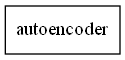

In [19]:
tf.keras.utils.plot_model(autoencoder, expand_nested=True)

In [20]:
loss_fn=tf.keras.losses.MeanSquaredError()
bce_fn=tf.keras.losses.BinaryCrossentropy(from_logits=False)
# def loss(model,input_features, obs,var,loss_fn=loss_fn,bce_fn=bce_fn):
#   output=model(input_features,var)
#   reconstruction_error = tf.reduce_mean(loss_fn(obs[0:3],output[0:3]))
#   reconstruction_error+=tf.reduce_mean(bce_fn(obs[3:], output[3:]))
#   return reconstruction_error

@tf.function  
def train(model,input_features,obs,var,opt,loss_fn=loss_fn,bce_fn=bce_fn):
  with tf.GradientTape() as tape:
    output1,output2=model([input_features,var])
    #losses = [tf.reduce_mean(loss_fn(obs[:,:,0:3],output1)),tf.reduce_mean((bce_fn(obs[:,:,3], output2[:,:,0])+bce_fn(obs[:,:,4], output2[:,:,1])))]
    losses = [tf.reduce_mean(loss_fn(obs[:,:,0:3],output1)),tf.reduce_mean((bce_fn(obs[:,:,3], output2[:,:,0])+bce_fn(obs[:,:,4], output2[:,:,1])))]
  gradients = tape.gradient(losses, model.trainable_variables)
  #print(gradients)
  gradient_variables = zip(gradients, model.trainable_variables)
  opt.apply_gradients(gradient_variables)
  return losses

In [21]:
autoencoder.trainable_variables

[]

In [22]:
print(bce_fn([0,1],[0.1,0.1]))
print(tf.reduce_mean(bce_fn([0],[0.1])+bce_fn([1],[0.1])))

tf.Tensor(1.2039723, shape=(), dtype=float32)
tf.Tensor(2.4079447, shape=(), dtype=float32)


In [23]:
def get_obs(state):
    return [state[0],state[1],state[4],state[6],state[7]]

In [24]:
def data_collection_per_eps(env,dqn_solver,autoencoder,maxt=1000,upgrade_every=50):

    S_series=[]
    #S_actual_series=[]
    O_series=[]
    U_series=[]
    R_series=[]
    O_predicted_series=[]
    Done_series=[]
    O_series.append(np.array([[0.0,0.0,0.0,0.0,0.0]]))
    O_predicted_series.append(np.array([[0.0,0.0,0.0,0.0,0.0]]))
    # encoder=autoencoder.encoder
    # decoder1=autoencoder.decoder1
    # decoder2=autoencoder.decoder2
    #dqn_solver.positive_rewards_list=[]
    i=0
    s0=env.reset()
    s0=s0[0]
    #s0=np.reshape(s0,[1,state_space])
    
    step=0
    done=False
    truncated=False
    for t in range(maxt):
        
        if(step==0):
            s=s0
            #S_actual_series.append(s)
        else:
            s=autoencoder.encode(tf.concat((S_series[i-1],O_series[i],U_series[i-1]),axis=1))
            s=np.reshape(s,(1,state_space))
            # s=s.tolist()
            # s[0][0]=np.tanh(s[0][0])*4.8
            # s[0][2]=np.tanh(s[0][2])*0.418
            # s=np.array(s)
            

        s=np.reshape(s,(1,state_space))
        S_series.append(s)
        #print(S_series,U_series,R_series,S_series,Done_series)
        if((i>1)and (not(step==0))):
            dqn_solver.remember(S_series[i-1][0],U_series[i-1][0][0],R_series[i-1],S_series[i][0],Done_series[i-1])
            loss=dqn_solver.train()
        action=dqn_solver.act(s)

        actual_state, reward, done,truncated,_ = env.step(int(action))
        obs=get_obs(actual_state)
        Done_series.append(done)
        #actual_state=np.reshape(actual_state,[1,state_space])
        #S_actual_series.append(actual_state)
        action=np.array([[action]])
        action=action.astype('float32')
        U_series.append(action)
        obs=np.reshape(obs,[1,obs_space])

        O_series.append(obs)
        # if(reward>10):
        #     dqn_solver.positive_rewards_list.append(i)
        R_series.append(reward)
        # print(s.shape)
        # print(action.shape)
        obs_pred1=autoencoder.decode1([s,tf.convert_to_tensor(action)])
        obs_pred2=autoencoder.decode2([s,tf.convert_to_tensor(action)])
        #print(obs_pred2)
        obs_pred=np.concatenate((obs_pred1,obs_pred2),axis=1)
        obs_pred=np.reshape(obs_pred,[1,obs_space])
        obs_pred=obs_pred.tolist()
        # obs_pred[0][0]=np.tanh(obs_pred[0][0])*4.8
        # obs_pred[0][1]=np.tanh(obs_pred[0][1])*0.418
        obs_pred=np.array(obs_pred)
        O_predicted_series.append(obs_pred)
        i+=1
        step+=1

        # if(t%upgrade_every==0):
        #     dqn_solver.update_target_model()
        #print(env.game_over)
        if(done==True):
            terminal_state_pred=autoencoder.encode(tf.concat((S_series[i-1],O_series[i],U_series[i-1]),axis=1))
            terminal_state_pred=np.reshape(terminal_state_pred,(1,state_space))[0]
            # print(terminal_state_pred)
            # print(S_series[i-1][0])
            # print(R_series[i-1])
            dqn_solver.remember(S_series[i-1][0],U_series[i-1][0][0],R_series[i-1],terminal_state_pred,Done_series[i-1])
            dqn_solver.train()
            break

    
    return S_series,O_series,U_series,R_series,O_predicted_series,Done_series


In [25]:
def data_collection_over_eps(total_episodes,env,dqn_solver,autoencoder,maxt=1000):
    main_list=[]
    ep_no=0
    while(ep_no<total_episodes):
        temp=[]
        S_series,O_series,U_series,R_series,O_predicted_series,Done_series=data_collection_per_eps(env,dqn_solver,autoencoder,maxt=1000)
        temp.append(S_series)
        temp.append(U_series)
        temp.append(O_series)
        temp.append(R_series)
        temp.append(O_predicted_series)
        main_list.append(temp)
        if(ep_no%2==0):
            dqn_solver.update_target_model()
        dqn_solver.decrement_epsilon()
        ep_no+=1
    return main_list

In [26]:
def autoencoder_training_per_eps(epochs,autoencoder,S_series,O_series,U_series,opt):
    temp1=[]
    temp2=[]
    temp3=[]
    losses=[]
    random_list=[]
    #print(len(S_series))
    if(len(S_series)<15005):
        random_list=list(range(2,len(S_series)-1))
    else:
        random_list=sample(list(range(2,len(S_series)-1)),15000)
    for i in random_list:
        temp1.append(tf.concat((S_series[i-1],O_series[i],U_series[i-1]),axis=1))
        temp2.append(O_series[i+1])
        temp3.append(U_series[i])
    input_features_dataset=tf.data.Dataset.from_tensor_slices(temp1).batch(32,drop_remainder=False)
    O_actual_dataset=tf.data.Dataset.from_tensor_slices(temp2).batch(32,drop_remainder=False)
    var_dataset=tf.data.Dataset.from_tensor_slices(temp3).batch(32,drop_remainder=False)
    final_dataset=tf.data.Dataset.zip((input_features_dataset, O_actual_dataset,var_dataset))

    for epoch in range(epochs):
        for x in final_dataset:
#             if(epoch==0 and i==0):
#                 print("initial loss " ,loss(autoencoder,x[0],x[1],x[2]))
            losses=train(autoencoder,x[0],x[1],x[2],opt)
            #print(losses)
#             if(epoch==(epochs-1) and i==0):
#                 print("final loss ",loss(autoencoder,x[0],x[1],x[2]))
        #time.sleep(0.1)
    #print(losses)
    del temp1
    del temp2
    del temp3
    del final_dataset
    del input_features_dataset
    del var_dataset
    del O_actual_dataset
    gc.collect()
    return losses

In [27]:
def autoencoder_training_over_eps(epochs,autoencoder,main_list,opt):
    S_series=[]
    O_series=[]
    U_series=[]
    for eps in trange(len(main_list),leave=False):
        S_series=main_list[eps][0]
        U_series=main_list[eps][1]
        O_series=main_list[eps][2]
        losses=autoencoder_training_per_eps(epochs,autoencoder,S_series,O_series,U_series,opt)
    print(losses)

In [28]:
def final_loop(total_episodes,env,dqn_solver,autoencoder,maxt=1000):
    loss={}
    S_series=[]
    #S_actual_series=[]
    O_series=[]
    U_series=[]
    R_series=[]
    O_predicted_series=[]
    Done_series=[]
    O_series.append(np.array([[0.0,0.0,0.0,0.0,0.0]]))
    O_predicted_series.append(np.array([[0.0,0.0,0.0,0.0,0.0]]))
    # encoder=autoencoder.encoder
    # decoder1=autoencoder.decoder1
    # decoder2=autoencoder.decoder2
    #dqn_solver.positive_rewards_list=[]
    ep_reward_list=[]
    ep_no=0
    i=0
    while(ep_no<total_episodes):
        s0=env.reset()
        s0=s0[0]
        #s0=np.reshape(s0,[1,state_space])
        ep_reward_sum=0
        step=0
        done=False
        truncated=False
        for t in range(maxt):
            if(step==0):
                s=s0
                #S_actual_series.append(s)
            else:
                s=autoencoder.encode(tf.concat((S_series[i-1],O_series[i],U_series[i-1]),axis=1))
                s=np.reshape(s,(1,state_space))
                # s=s.tolist()
                # s[0][0]=np.tanh(s[0][0])*4.8
                # s[0][2]=np.tanh(s[0][2])*0.418
                # s=np.array(s)
                

            s=np.reshape(s,(1,state_space))
            S_series.append(s)
            #print(S_series,U_series,R_series,S_series,Done_series)
            if((i>0)and(step>0)):
                #print(len(S_series),len(U_series),len(O_series))
                dqn_solver.remember(S_series[i-1][0],U_series[i-1][0][0],R_series[i-1],S_series[i][0],Done_series[i-1])
                loss=dqn_solver.train()
            action=dqn_solver.act(s)

            actual_state, reward, done,truncated,_ = env.step(int(action))
            ep_reward_sum+=reward
            obs=get_obs(actual_state)
            Done_series.append(done)
            #actual_state=np.reshape(actual_state,[1,state_space])
            #S_actual_series.append(actual_state)
            action=np.array([[action]])
            action=action.astype('float32')
            U_series.append(action)
            obs=np.reshape(obs,[1,obs_space])

            O_series.append(obs)
            # if(reward>10):
            #     dqn_solver.positive_rewards_list.append(i)
            R_series.append(reward)
            # print(s.shape)
            # print(action.shape)
            obs_pred1=autoencoder.decode1([s,action])
            obs_pred2=autoencoder.decode2([s,action])
            #print(obs_pred2)
            obs_pred=np.concatenate((obs_pred1,obs_pred2),axis=1)
            obs_pred=np.reshape(obs_pred,[1,obs_space])
            #obs_pred=obs_pred.tolist()
            # obs_pred[0][0]=np.tanh(obs_pred[0][0])*4.8
            # obs_pred[0][1]=np.tanh(obs_pred[0][1])*0.418
            #obs_pred=np.array(obs_pred)
            O_predicted_series.append(obs_pred)
            i+=1
            step+=1
            #print(env.game_over)
            if(done==True):
                terminal_state_pred=autoencoder.encode(tf.concat((S_series[i-1],O_series[i],U_series[i-1]),axis=1))
                terminal_state_pred=np.reshape(terminal_state_pred,(1,state_space))[0]
                dqn_solver.remember(S_series[i-1][0],U_series[i-1][0][0],R_series[i-1],terminal_state_pred,Done_series[i-1])
                loss=dqn_solver.train()
                break
        ep_no+=1
        ep_reward_list.append(ep_reward_sum)
        if(ep_no%2==0):
            dqn_solver.update_target_model()
        dqn_solver.decrement_epsilon()
        if(ep_no%20==0):
            print(ep_reward_sum,dqn_solver.epsilon,loss)
    return ep_reward_list


In [29]:
def final_loop2(total_episodes,env,dqn_solver,autoencoder,maxt=1000):
    loss={}
    S_series=[]
    #S_actual_series=[]
    O_series=[]
    U_series=[]
    R_series=[]
    O_predicted_series=[]
    Done_series=[]
    O_series.append(np.array([[0.0,0.0,0.0,0.0,0.0]]))
    O_predicted_series.append(np.array([[0.0,0.0,0.0,0.0,0.0]]))
    # encoder=autoencoder.encoder
    # decoder1=autoencoder.decoder1
    # decoder2=autoencoder.decoder2
    #dqn_solver.positive_rewards_list=[]
    ep_reward_list=[]
    ep_no=0
    i=0
    while(ep_no<total_episodes):
        s0=env.reset()
        s0=s0[0]
        #s0=np.reshape(s0,[1,state_space])
        ep_reward_sum=0
        step=0
        done=False
        truncated=False
        for t in range(maxt):
            if(step==0):
                s=s0
                #S_actual_series.append(s)
            else:
                s=autoencoder.encode(tf.concat((S_series[i-1],O_series[i],U_series[i-1]),axis=1))
                s=np.reshape(s,(1,state_space))
                # s=s.tolist()
                # s[0][0]=np.tanh(s[0][0])*4.8
                # s[0][2]=np.tanh(s[0][2])*0.418
                # s=np.array(s)
                

            s=np.reshape(s,(1,state_space))
            S_series.append(s)
            #print(S_series,U_series,R_series,S_series,Done_series)
            if((i>0)):
                #print(len(S_series),len(U_series),len(O_series))
                dqn_solver.remember(S_series[i-1][0],U_series[i-1][0][0],R_series[i-1],S_series[i][0],Done_series[i-1])
                loss=dqn_solver.train()
            action=dqn_solver.act(s)

            actual_state, reward, done,truncated,_ = env.step(int(action))
            ep_reward_sum+=reward
            obs=get_obs(actual_state)
            Done_series.append(done)
            #actual_state=np.reshape(actual_state,[1,state_space])
            #S_actual_series.append(actual_state)
            action=np.array([[action]])
            action=action.astype('float32')
            U_series.append(action)
            obs=np.reshape(obs,[1,obs_space])

            O_series.append(obs)
            # if(reward>10):
            #     dqn_solver.positive_rewards_list.append(i)
            R_series.append(reward)
            # print(s.shape)
            # print(action.shape)
            obs_pred1=autoencoder.decode1([s,action])
            obs_pred2=autoencoder.decode2([s,action])
            #print(obs_pred2)
            obs_pred=np.concatenate((obs_pred1,obs_pred2),axis=1)
            obs_pred=np.reshape(obs_pred,[1,obs_space])
            #obs_pred=obs_pred.tolist()
            # obs_pred[0][0]=np.tanh(obs_pred[0][0])*4.8
            # obs_pred[0][1]=np.tanh(obs_pred[0][1])*0.418
            #obs_pred=np.array(obs_pred)
            O_predicted_series.append(obs_pred)
            i+=1
            step+=1
            #print(env.game_over)
            if(done==True):
                # terminal_state_pred=autoencoder.encode(tf.concat((S_series[i-1],O_series[i],U_series[i-1]),axis=1))
                # terminal_state_pred=np.reshape(terminal_state_pred,(1,state_space))[0]
                # dqn_solver.remember(S_series[i-1][0],U_series[i-1][0][0],R_series[i-1],terminal_state_pred,Done_series[i-1])
                # loss=dqn_solver.train()
                break
        ep_no+=1
        ep_reward_list.append(ep_reward_sum)
        if(ep_no%2==0):
            dqn_solver.update_target_model()
        dqn_solver.decrement_epsilon()
        if(ep_no%20==0):
            print(ep_reward_sum,dqn_solver.epsilon,loss)
    return ep_reward_list


In [30]:
#S_series,O_series,U_series,R_series,O_predicted_series,Done_series=data_collection(2,env,dqn_solver,autoencoder)

In [31]:
# dqn_solver.forget()
# for i in range(len(S_series)-1):
#     dqn_solver.remember(S_series[i][0],U_series[i][0][0],R_series[i],S_series[i+1][0],Done_series[i])
# dqn_solver.find_positive_rewards()

In [32]:
# dqn_solver.positive_rewards_list

In [33]:
# dqn_solver.minibatch()

In [34]:
#main_list=data_collection_over_eps(10,env,dqn_solver,autoencoder)

In [35]:
rewards_storage=[]

In [36]:
def complete_loop(autoencoder,dqn_solver,epochs):
    opt=tf.keras.optimizers.Adam(learning_rate=1e-6)
    flag=0
    complete_eps=100
    for epoch in range(epochs):
        reward_sum=0
        # no_positive_rewards=0
        # no_100_rewards=0
        # for reward in R_series:
        #     if(reward>10):
        #         no_positive_rewards+=1
        #     if(reward>99):
        #         no_100_rewards+=1
        # print(no_positive_rewards,no_100_rewards)
        if(epoch<epochs-1):
            main_list=data_collection_over_eps(complete_eps,env,dqn_solver,autoencoder)
            for x in main_list:
                reward_sum+=sum(x[3])
            print("epoch: {}, epsilon {}, reward:{}".format(epoch, dqn_solver.epsilon, reward_sum))
        # print("epoch: {}, total reward: {}, number of steps: {}, epsilon {}".format(epoch, sum(R_series),len(S_series),dqn_solver.epsilon))
            rewards_storage.append(reward_sum)
            aenc_epochs=max(10,int(np.tanh(epoch/10)*50))
            autoencoder_training_over_eps(aenc_epochs,autoencoder,main_list,opt)
            dqn_solver.epsilon=1.0
            dqn_solver.forget()
            del main_list
            
        else:
            if epoch==epochs-1:
                dqn_solver.epsilon=1.0
                dqn_solver.decay_coe=0.995
                
            ep_reward_list=final_loop(2000,env,dqn_solver,autoencoder,maxt=1000)

        
        gc.collect()
        #time.sleep(0.1)
    return ep_reward_list

In [37]:
dqn_solver.model.Qpolicy.weights

[<tf.Variable 'dense/kernel:0' shape=(8, 512) dtype=float32, numpy=
 array([[ 0.07984447,  0.7046134 , -0.6837964 , ..., -0.7400877 ,
         -0.4931975 , -0.48368987],
        [ 0.14054221, -0.66717875,  0.8381612 , ..., -0.3930378 ,
          0.13944966, -0.09209764],
        [-0.62206364, -0.67277366,  0.80531245, ..., -0.08845288,
         -0.66806495, -0.0340963 ],
        ...,
        [-0.40457344, -0.7473078 , -0.0481016 , ...,  0.8322852 ,
          0.7849142 ,  0.14333993],
        [-0.01741982,  0.64825803,  0.07424217, ...,  0.21394628,
          0.39762944, -0.748373  ],
        [-0.6823709 ,  0.32169873,  0.43315166, ...,  0.67457396,
          0.50177807, -0.04758358]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(512,) dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [38]:
ep_reward_list=complete_loop(autoencoder,dqn_solver,21)

epoch: 0, epsilon 0.04755250792540567, reward:-16895.11537315101


[<tf.Tensor: shape=(), dtype=float32, numpy=1.3707275>, <tf.Tensor: shape=(), dtype=float32, numpy=1.1830637>]
epoch: 1, epsilon 0.04755250792540567, reward:-24448.04398607502


[<tf.Tensor: shape=(), dtype=float32, numpy=1.0795934>, <tf.Tensor: shape=(), dtype=float32, numpy=1.1292799>]
epoch: 2, epsilon 0.04755250792540567, reward:-22071.649792313405


[<tf.Tensor: shape=(), dtype=float32, numpy=2.4073315>, <tf.Tensor: shape=(), dtype=float32, numpy=1.2411917>]
epoch: 3, epsilon 0.04755250792540567, reward:-25754.018914311517


[<tf.Tensor: shape=(), dtype=float32, numpy=5.249007>, <tf.Tensor: shape=(), dtype=float32, numpy=0.9241166>]
epoch: 4, epsilon 0.04755250792540567, reward:-13377.878639994997


[<tf.Tensor: shape=(), dtype=float32, numpy=1.339251>, <tf.Tensor: shape=(), dtype=float32, numpy=1.1210247>]
epoch: 5, epsilon 0.04755250792540567, reward:-17750.254933221364


[<tf.Tensor: shape=(), dtype=float32, numpy=0.72779983>, <tf.Tensor: shape=(), dtype=float32, numpy=0.972059>]
epoch: 6, epsilon 0.04755250792540567, reward:-12416.866194460514


[<tf.Tensor: shape=(), dtype=float32, numpy=0.4044426>, <tf.Tensor: shape=(), dtype=float32, numpy=0.90101445>]
epoch: 7, epsilon 0.04755250792540567, reward:-14069.422432303845


[<tf.Tensor: shape=(), dtype=float32, numpy=1.0578979>, <tf.Tensor: shape=(), dtype=float32, numpy=0.65543604>]
epoch: 8, epsilon 0.04755250792540567, reward:-10993.828248019108


[<tf.Tensor: shape=(), dtype=float32, numpy=1.2302157>, <tf.Tensor: shape=(), dtype=float32, numpy=0.4573177>]
epoch: 9, epsilon 0.04755250792540567, reward:-13308.345119613534


[<tf.Tensor: shape=(), dtype=float32, numpy=0.41528633>, <tf.Tensor: shape=(), dtype=float32, numpy=0.87559414>]
epoch: 10, epsilon 0.04755250792540567, reward:-8870.420523068793


[<tf.Tensor: shape=(), dtype=float32, numpy=1.6565477>, <tf.Tensor: shape=(), dtype=float32, numpy=0.39392948>]
epoch: 11, epsilon 0.04755250792540567, reward:-11050.750740335665


[<tf.Tensor: shape=(), dtype=float32, numpy=0.14833525>, <tf.Tensor: shape=(), dtype=float32, numpy=0.43672168>]
epoch: 12, epsilon 0.04755250792540567, reward:-8003.116564367218


[<tf.Tensor: shape=(), dtype=float32, numpy=0.052233346>, <tf.Tensor: shape=(), dtype=float32, numpy=0.30512568>]
epoch: 13, epsilon 0.04755250792540567, reward:-8544.462834032514


[<tf.Tensor: shape=(), dtype=float32, numpy=0.2085599>, <tf.Tensor: shape=(), dtype=float32, numpy=0.34687412>]
epoch: 14, epsilon 0.04755250792540567, reward:-7504.342058908591


[<tf.Tensor: shape=(), dtype=float32, numpy=0.36855102>, <tf.Tensor: shape=(), dtype=float32, numpy=0.52306795>]
epoch: 15, epsilon 0.04755250792540567, reward:-8779.724622826572


[<tf.Tensor: shape=(), dtype=float32, numpy=0.13170928>, <tf.Tensor: shape=(), dtype=float32, numpy=0.43563068>]
epoch: 16, epsilon 0.04755250792540567, reward:-8549.916466930586


[<tf.Tensor: shape=(), dtype=float32, numpy=0.05943286>, <tf.Tensor: shape=(), dtype=float32, numpy=1.0616693>]
epoch: 17, epsilon 0.04755250792540567, reward:-10465.290146534295


[<tf.Tensor: shape=(), dtype=float32, numpy=0.15198906>, <tf.Tensor: shape=(), dtype=float32, numpy=0.27678815>]
epoch: 18, epsilon 0.04755250792540567, reward:-8458.485725611074


[<tf.Tensor: shape=(), dtype=float32, numpy=0.048609994>, <tf.Tensor: shape=(), dtype=float32, numpy=0.6865028>]
epoch: 19, epsilon 0.04755250792540567, reward:-7994.269584616015


[<tf.Tensor: shape=(), dtype=float32, numpy=0.019536963>, <tf.Tensor: shape=(), dtype=float32, numpy=0.31573907>]
14.63572713779314 0.9046104802746175 {'loss': 4.497084140777588, 'accuracy': 0.796875}
52.54991731147783 0.8183201210226743 {'loss': 1.8963686227798462, 'accuracy': 0.765625}
-54.13587781008681 0.7402609576967045 {'loss': 3.8032093048095703, 'accuracy': 0.71875}
-7.675848386040808 0.6696478204705644 {'loss': 2.1494829654693604, 'accuracy': 0.765625}
31.349599327419682 0.6057704364907278 {'loss': 4.9159255027771, 'accuracy': 0.71875}
-356.99603710574576 0.547986285490042 {'loss': 2.3921236991882324, 'accuracy': 0.71875}
-202.30755739838247 0.49571413690105054 {'loss': 2.684342622756958, 'accuracy': 0.8125}
-266.8696808973102 0.4484282034609769 {'loss': 6.227670669555664, 'accuracy': 0.671875}
-8.683326955929624 0.40565285250151817 {'loss': 3.088454246520996, 'accuracy': 0.59375}
-187.59935163366123 0.3669578217261671 {'loss': 5.431790828704834, 'accuracy': 0.625}
-43.7883765

In [ ]:
ep_reward_list3=final_loop(4000,env,dqn_solver,autoencoder,maxt=1000)

-98.3630227742443 0.01 {'loss': nan, 'accuracy': 1.0}
-88.40185533504015 0.01 {'loss': nan, 'accuracy': 1.0}
-39.65083296771826 0.01 {'loss': nan, 'accuracy': 1.0}
-64.99181877282692 0.01 {'loss': nan, 'accuracy': 1.0}
-141.8957401737088 0.01 {'loss': nan, 'accuracy': 1.0}
-104.66683953114517 0.01 {'loss': nan, 'accuracy': 1.0}
-74.71936834125026 0.01 {'loss': nan, 'accuracy': 1.0}
-76.35685743015095 0.01 {'loss': nan, 'accuracy': 1.0}
-67.86357907642582 0.01 {'loss': nan, 'accuracy': 1.0}
-27.32432265449191 0.01 {'loss': nan, 'accuracy': 1.0}
-31.56246708083367 0.01 {'loss': nan, 'accuracy': 1.0}
-81.46989108250497 0.01 {'loss': nan, 'accuracy': 1.0}
-11.56938337640871 0.01 {'loss': nan, 'accuracy': 1.0}
-102.00694468203024 0.01 {'loss': nan, 'accuracy': 1.0}
-87.93631048927764 0.01 {'loss': nan, 'accuracy': 1.0}
-49.27365143369974 0.01 {'loss': nan, 'accuracy': 1.0}
-42.2135346104954 0.01 {'loss': nan, 'accuracy': 1.0}
-47.035027755963256 0.01 {'loss': nan, 'accuracy': 1.0}
-43.21753

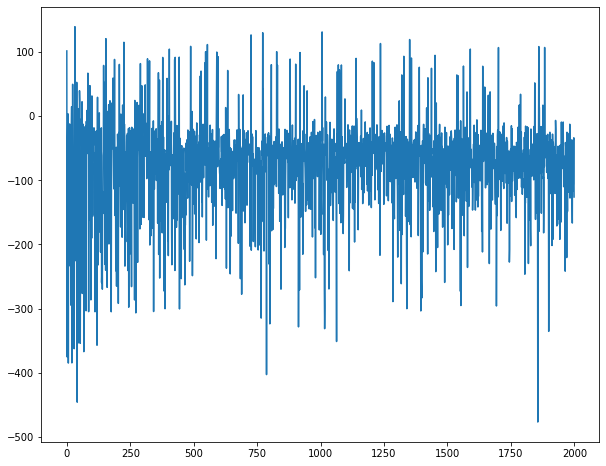

In [39]:
plt.rcParams['figure.figsize']=[10,8]
plt.plot(ep_reward_list)


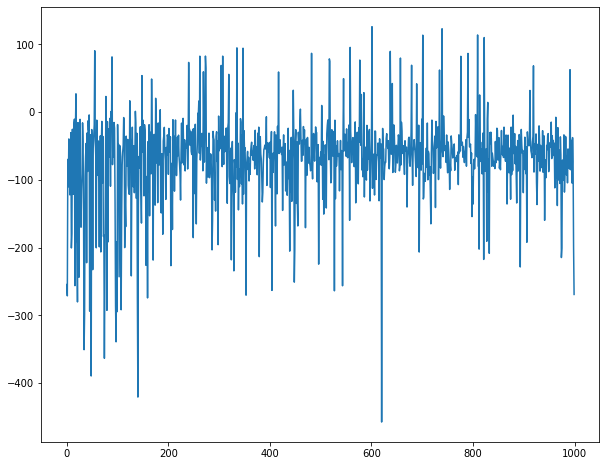

In [ ]:
plt.plot(ep_reward_list[0:1000])

In [ ]:
import pandas as pd
df=pd.DataFrame(ep_reward_list)
df.columns=['scores']
df.to_csv('rewards_main_algo_lunar_09-05.csv')

In [ ]:
plt.plot(ep_reward_list2)

NameError: name 'ep_reward_list2' is not defined

In [40]:
dqn_solver_new=DQNSolver(state_space=state_space,action_space=action_space)
dqn_solver_new.decay_coe=0.995


In [41]:
dqn_solver_new.model.Qpolicy.weights

[<tf.Variable 'dense_17/kernel:0' shape=(8, 512) dtype=float32, numpy=
 array([[-0.16469371,  0.6071903 , -0.18836462, ..., -0.5468899 ,
          0.02899754, -0.39806345],
        [-0.39893064,  0.53426486,  0.20090657, ..., -0.24482793,
         -0.7146052 ,  0.7808865 ],
        [ 0.28764063, -0.47964314,  0.08242071, ..., -0.4024044 ,
          0.00671113, -0.6310749 ],
        ...,
        [ 0.51655966,  0.01197731, -0.7710499 , ...,  0.67179936,
         -0.8535631 , -0.32159215],
        [-0.06369615, -0.5448468 , -0.15048653, ..., -0.3897348 ,
          0.37436575,  0.3421077 ],
        [-0.11411381,  0.447918  , -0.25940043, ..., -0.2263307 ,
          0.19303983,  0.5405007 ]], dtype=float32)>,
 <tf.Variable 'dense_17/bias:0' shape=(512,) dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [42]:
dqn_solver_new.lr

1e-06

In [43]:
ep_reward_list2=final_loop2(2000,env,dqn_solver_new,autoencoder,maxt=1000)

-103.91169092347326 0.9046104802746175 {'loss': 4.7157087326049805, 'accuracy': 0.703125}
-140.49045087736965 0.8183201210226743 {'loss': 0.9666653871536255, 'accuracy': 0.71875}
-353.87636616168106 0.7402609576967045 {'loss': 2.6453495025634766, 'accuracy': 0.578125}
-112.59525583514927 0.6696478204705644 {'loss': 5.319663047790527, 'accuracy': 0.625}
-38.07341989423824 0.6057704364907278 {'loss': 3.7717180252075195, 'accuracy': 0.578125}
-82.13229173971571 0.547986285490042 {'loss': 1.3696786165237427, 'accuracy': 0.609375}
-292.630648244274 0.49571413690105054 {'loss': 2.7976813316345215, 'accuracy': 0.65625}
125.31651895701418 0.4484282034609769 {'loss': 3.9978911876678467, 'accuracy': 0.703125}
-72.98606080296983 0.40565285250151817 {'loss': 3.200767993927002, 'accuracy': 0.578125}
-51.09359069050913 0.3669578217261671 {'loss': 1.5652132034301758, 'accuracy': 0.6875}
-202.97609140483462 0.33195389135223546 {'loss': 16.602754592895508, 'accuracy': 0.6875}
-13.062917044319022 0.3002

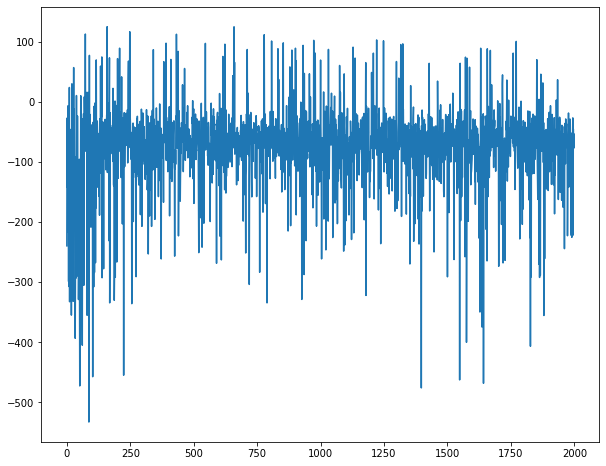

In [44]:
plt.plot(ep_reward_list2)

In [ ]:
ep_reward_list3=final_loop(10,env,dqn_solver_new,autoencoder,maxt=1000)

2 1 2
3 2 3
4 3 4
5 4 5
6 5 6
7 6 7
8 7 8
9 8 9
10 9 10
11 10 11
12 11 12
13 12 13
14 13 14
15 14 15
16 15 16
17 16 17
18 17 18
19 18 19
20 19 20
21 20 21
22 21 22
23 22 23
24 23 24
25 24 25
26 25 26
27 26 27
28 27 28
29 28 29
30 29 30
31 30 31
32 31 32
33 32 33
34 33 34
35 34 35
36 35 36
37 36 37
38 37 38
39 38 39
40 39 40
41 40 41
42 41 42
43 42 43
44 43 44
45 44 45
46 45 46
47 46 47
48 47 48
49 48 49
50 49 50
51 50 51
52 51 52
53 52 53
54 53 54
55 54 55
56 55 56
57 56 57
58 57 58
59 58 59
60 59 60
61 60 61
62 61 62
63 62 63
64 63 64
65 64 65
66 65 66
67 66 67
68 67 68
69 68 69
70 69 70
71 70 71
72 71 72
73 72 73
74 73 74
75 74 75
76 75 76
78 77 78
79 78 79
80 79 80
81 80 81
82 81 82
83 82 83
84 83 84
85 84 85
86 85 86
87 86 87
88 87 88
89 88 89
90 89 90
91 90 91
92 91 92
93 92 93
94 93 94
95 94 95
96 95 96
97 96 97
98 97 98
99 98 99
100 99 100
101 100 101
102 101 102
103 102 103
104 103 104
105 104 105
106 105 106
107 106 107
108 107 108
109 108 109
110 109 110
111 110 111
112 111 1

Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x000002171CAB9820>
Traceback (most recent call last):
  File "c:\Users\prati\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\data\ops\iterator_ops.py", line 545, in __del__
    gen_dataset_ops.delete_iterator(
  File "c:\Users\prati\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\ops\gen_dataset_ops.py", line 1262, in delete_iterator
    _result = pywrap_tfe.TFE_Py_FastPathExecute(
KeyboardInterrupt: 


225 224 225
226 225 226
227 226 227
228 227 228
229 228 229
230 229 230
231 230 231
232 231 232
233 232 233
234 233 234
235 234 235
236 235 236
237 236 237
238 237 238
239 238 239
240 239 240
241 240 241
242 241 242
243 242 243
244 243 244
246 245 246
247 246 247
248 247 248
249 248 249
250 249 250
251 250 251
252 251 252
253 252 253
254 253 254
255 254 255
256 255 256
257 256 257
258 257 258
259 258 259
260 259 260
261 260 261
262 261 262
263 262 263
264 263 264
265 264 265
266 265 266
267 266 267
268 267 268
269 268 269
270 269 270
271 270 271
272 271 272
273 272 273
274 273 274
275 274 275
276 275 276
277 276 277
278 277 278
279 278 279
280 279 280
281 280 281
282 281 282
283 282 283
284 283 284
285 284 285
286 285 286
287 286 287
288 287 288
289 288 289
290 289 290
291 290 291
292 291 292
293 292 293
294 293 294
295 294 295
296 295 296
297 296 297
298 297 298
299 298 299
300 299 300
301 300 301
302 301 302
303 302 303
304 303 304
305 304 305
306 305 306
307 306 307
308 307 308
309 

KeyboardInterrupt: 

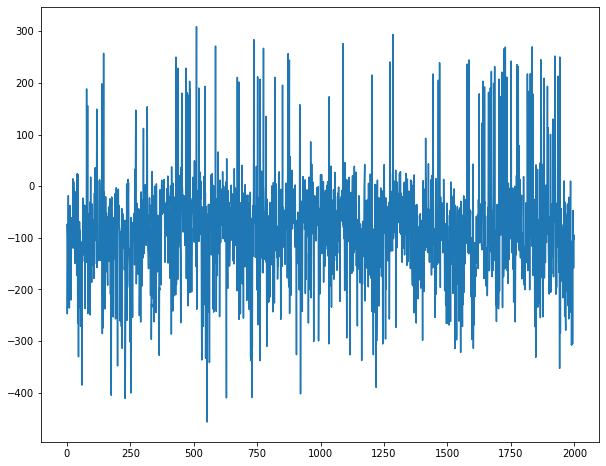

In [ ]:
plt.plot(ep_reward_list3)

In [ ]:
autoencoder.save('aenc_04-05')

INFO:tensorflow:Assets written to: aenc_04-05\assets


INFO:tensorflow:Assets written to: aenc_04-05\assets


In [ ]:
autoencoder.save_weights('aenc_weights_14-05')

In [ ]:
dqn_solver_new2=DQNSolver(state_space=state_space,action_space=action_space)
dqn_solver_new2.decay_coe=0.995

In [ ]:
ep_reward_list4=final_loop(4000,env,dqn_solver_new2,autoencoder,maxt=1000)

-106.8209598113674 0.9046104802746175 {'loss': 4.091190814971924, 'accuracy': 0.640625}
-307.1774337528546 0.8183201210226743 {'loss': 1.5597753524780273, 'accuracy': 0.71875}
-110.30034428320543 0.7402609576967045 {'loss': 34.211891174316406, 'accuracy': 0.765625}
-372.6373208974319 0.6696478204705644 {'loss': 4.044637203216553, 'accuracy': 0.59375}
-170.83934115817377 0.6057704364907278 {'loss': 33.989173889160156, 'accuracy': 0.734375}
-196.65010761577682 0.547986285490042 {'loss': 35.23976516723633, 'accuracy': 0.734375}
-212.2450067712321 0.49571413690105054 {'loss': 46.00014114379883, 'accuracy': 0.65625}
-217.34959435497527 0.4484282034609769 {'loss': 3.2377147674560547, 'accuracy': 0.609375}
-183.1622548732657 0.40565285250151817 {'loss': 4.832193374633789, 'accuracy': 0.71875}
-145.5473925857373 0.3669578217261671 {'loss': 2.159571886062622, 'accuracy': 0.65625}
-86.05814292166255 0.33195389135223546 {'loss': 2.581482410430908, 'accuracy': 0.640625}
-60.22886260501659 0.300288

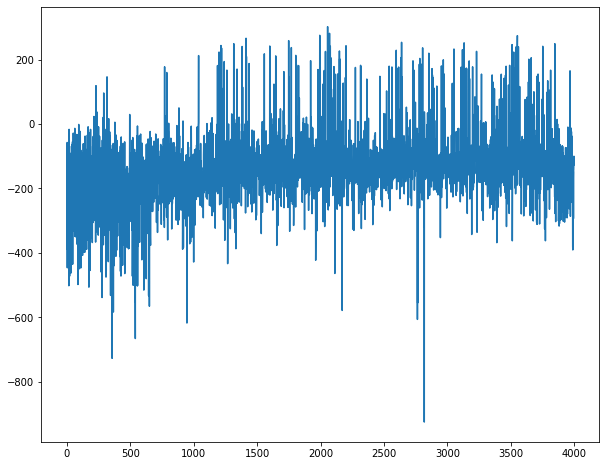

In [ ]:
plt.plot(ep_reward_list4)

In [ ]:
ep_reward_list5=final_loop(1000,env,dqn_solver_new2,autoencoder,maxt=1000)

-92.11706977146237 0.01 {'loss': 1.8529000282287598, 'accuracy': 0.71875}
31.15862374235391 0.01 {'loss': 2.7139477729797363, 'accuracy': 0.65625}
-45.333464674599796 0.01 {'loss': 3.430366039276123, 'accuracy': 0.625}
-125.53739067044206 0.01 {'loss': 12.758081436157227, 'accuracy': 0.59375}
-97.03198535418312 0.01 {'loss': 4.727921485900879, 'accuracy': 0.640625}
3.7930196225956934 0.01 {'loss': 1.5885227918624878, 'accuracy': 0.65625}
-87.46397807344471 0.01 {'loss': 2.146149158477783, 'accuracy': 0.71875}
-82.75624880283318 0.01 {'loss': 16.460346221923828, 'accuracy': 0.53125}
-130.78906271766215 0.01 {'loss': 3.752660036087036, 'accuracy': 0.703125}
-164.98624545481235 0.01 {'loss': 1.5197644233703613, 'accuracy': 0.65625}
-65.89650226714514 0.01 {'loss': 1.433044672012329, 'accuracy': 0.671875}
-104.62772883397439 0.01 {'loss': 1.4958858489990234, 'accuracy': 0.53125}
-80.34254307666379 0.01 {'loss': 1.2491645812988281, 'accuracy': 0.625}
-157.62029875908328 0.01 {'loss': 2.0207

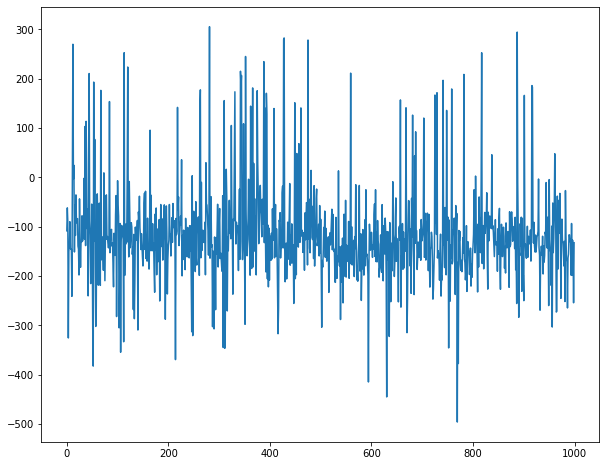

In [ ]:
plt.plot(ep_reward_list5)

In [ ]:
import pandas as pd
df=pd.DataFrame(ep_reward_list4)
df.columns=['scores']
df.to_csv('rewards_main_algo_05-05.csv')

In [ ]:
df['moving_avg']=df.scores.rolling(10,min_periods=1).mean()

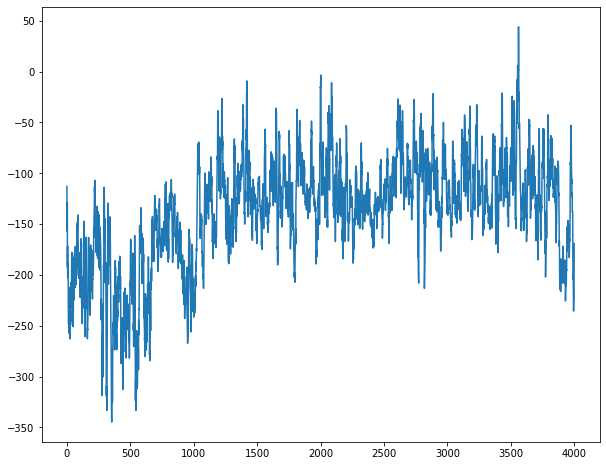

In [ ]:
plt.plot(df['moving_avg'])

In [ ]:
env_render= gym.make(
        "LunarLander-v2",
        continuous = False,
        gravity = -10.0,
        enable_wind = True,
        wind_power  = 5.0,
        turbulence_power = 0.5,
        render_mode="human"
    )

In [ ]:
main_list=data_collection_over_eps(10,env,dqn_solver_new,autoencoder)

In [ ]:
env_render.close()

In [ ]:
main_list[5][2]

[array([[0., 0., 0., 0., 0.]]),
 array([[ 0.00311394,  1.4070934 , -0.0039071 ,  0.        ,  0.        ]],
       dtype=float32),
 array([[ 0.00479584,  1.4042932 , -0.00810326,  0.        ,  0.        ]],
       dtype=float32),
 array([[ 0.00641699,  1.4008999 , -0.01018286,  0.        ,  0.        ]],
       dtype=float32),
 array([[ 0.00815268,  1.396894  , -0.0145612 ,  0.        ,  0.        ]],
       dtype=float32),
 array([[ 0.00983486,  1.392294  , -0.01700835,  0.        ,  0.        ]],
       dtype=float32),
 array([[ 0.01154699,  1.3870941 , -0.01962555,  0.        ,  0.        ]],
       dtype=float32),
 array([[ 0.01325264,  1.3825264 , -0.02266565,  0.        ,  0.        ]],
       dtype=float32),
 array([[ 0.01498842,  1.3773584 , -0.02588343,  0.        ,  0.        ]],
       dtype=float32),
 array([[ 0.01684885,  1.3715808 , -0.03167059,  0.        ,  0.        ]],
       dtype=float32),
 array([[ 0.0187397 ,  1.3652037 , -0.03764239,  0.        ,  0.        ]],
 

In [ ]:
autoencoder.encoder.weights

[<tf.Variable 'encoder/dense_8/kernel:0' shape=(14, 16) dtype=float32, numpy=
 array([[-6.45771146e-01,  3.62815142e-01, -6.90871552e-02,
         -2.97124177e-01, -3.95335466e-01, -2.78443396e-01,
         -6.57278597e-02, -3.81341204e-02, -2.54255861e-01,
         -2.89216731e-03, -1.46814749e-01, -2.09944457e-01,
          3.26801509e-01,  3.31465900e-01, -9.10797492e-02,
         -2.18307480e-01],
        [-5.55226684e-01,  3.22981805e-01,  6.48095787e-01,
         -1.50206879e-01, -4.06527579e-01,  4.28591728e-01,
          1.39798447e-01, -4.02157605e-01, -3.36946696e-01,
          3.44043702e-01,  1.78054467e-01,  3.33201975e-01,
          7.29824007e-02, -2.66011655e-01, -4.48510945e-01,
          3.70133400e-01],
        [ 4.55131203e-01,  2.61558354e-01, -4.63469893e-01,
          2.47227937e-01, -9.81986523e-02, -6.45640016e-01,
         -1.75910488e-01,  1.29615933e-01,  4.19547498e-01,
          1.20068565e-01,  1.95965633e-01, -3.54318887e-01,
          5.77408135e-01, -4

In [ ]:
autoencoder_training_over_eps(5,autoencoder,main_list,opt=tf.keras.optimizers.Adam(learning_rate=2.5e-5))


  0%|          | 0/10 [00:00<?, ?it/s]

[<tf.Tensor 'gradient_tape/autoencoder/encoder/dense_8/Tensordot/MatMul/MatMul:0' shape=(14, 16) dtype=float32>, <tf.Tensor 'gradient_tape/autoencoder/encoder/dense_8/BiasAdd/BiasAddGrad:0' shape=(16,) dtype=float32>, <tf.Tensor 'gradient_tape/autoencoder/encoder/dense_9/Tensordot/MatMul/MatMul_1:0' shape=(16, 16) dtype=float32>, <tf.Tensor 'gradient_tape/autoencoder/encoder/dense_9/BiasAdd/BiasAddGrad:0' shape=(16,) dtype=float32>, <tf.Tensor 'gradient_tape/autoencoder/encoder/dense_10/Tensordot/MatMul/MatMul_1:0' shape=(16, 8) dtype=float32>, <tf.Tensor 'gradient_tape/autoencoder/encoder/dense_10/BiasAdd/BiasAddGrad:0' shape=(8,) dtype=float32>, <tf.Tensor 'gradient_tape/autoencoder/decoder1/dense_11/Tensordot/MatMul/MatMul_1:0' shape=(9, 16) dtype=float32>, <tf.Tensor 'gradient_tape/autoencoder/decoder1/dense_11/BiasAdd/BiasAddGrad:0' shape=(16,) dtype=float32>, <tf.Tensor 'gradient_tape/autoencoder/decoder1/dense_12/Tensordot/MatMul/MatMul_1:0' shape=(16, 16) dtype=float32>, <tf.Te

 10%|█         | 1/10 [00:03<00:34,  3.79s/it]

[<tf.Tensor 'gradient_tape/autoencoder/encoder/dense_8/Tensordot/MatMul/MatMul:0' shape=(14, 16) dtype=float32>, <tf.Tensor 'gradient_tape/autoencoder/encoder/dense_8/BiasAdd/BiasAddGrad:0' shape=(16,) dtype=float32>, <tf.Tensor 'gradient_tape/autoencoder/encoder/dense_9/Tensordot/MatMul/MatMul_1:0' shape=(16, 16) dtype=float32>, <tf.Tensor 'gradient_tape/autoencoder/encoder/dense_9/BiasAdd/BiasAddGrad:0' shape=(16,) dtype=float32>, <tf.Tensor 'gradient_tape/autoencoder/encoder/dense_10/Tensordot/MatMul/MatMul_1:0' shape=(16, 8) dtype=float32>, <tf.Tensor 'gradient_tape/autoencoder/encoder/dense_10/BiasAdd/BiasAddGrad:0' shape=(8,) dtype=float32>, <tf.Tensor 'gradient_tape/autoencoder/decoder1/dense_11/Tensordot/MatMul/MatMul_1:0' shape=(9, 16) dtype=float32>, <tf.Tensor 'gradient_tape/autoencoder/decoder1/dense_11/BiasAdd/BiasAddGrad:0' shape=(16,) dtype=float32>, <tf.Tensor 'gradient_tape/autoencoder/decoder1/dense_12/Tensordot/MatMul/MatMul_1:0' shape=(16, 16) dtype=float32>, <tf.Te

 20%|██        | 2/10 [00:06<00:24,  3.02s/it]

[<tf.Tensor 'gradient_tape/autoencoder/encoder/dense_8/Tensordot/MatMul/MatMul:0' shape=(14, 16) dtype=float32>, <tf.Tensor 'gradient_tape/autoencoder/encoder/dense_8/BiasAdd/BiasAddGrad:0' shape=(16,) dtype=float32>, <tf.Tensor 'gradient_tape/autoencoder/encoder/dense_9/Tensordot/MatMul/MatMul_1:0' shape=(16, 16) dtype=float32>, <tf.Tensor 'gradient_tape/autoencoder/encoder/dense_9/BiasAdd/BiasAddGrad:0' shape=(16,) dtype=float32>, <tf.Tensor 'gradient_tape/autoencoder/encoder/dense_10/Tensordot/MatMul/MatMul_1:0' shape=(16, 8) dtype=float32>, <tf.Tensor 'gradient_tape/autoencoder/encoder/dense_10/BiasAdd/BiasAddGrad:0' shape=(8,) dtype=float32>, <tf.Tensor 'gradient_tape/autoencoder/decoder1/dense_11/Tensordot/MatMul/MatMul_1:0' shape=(9, 16) dtype=float32>, <tf.Tensor 'gradient_tape/autoencoder/decoder1/dense_11/BiasAdd/BiasAddGrad:0' shape=(16,) dtype=float32>, <tf.Tensor 'gradient_tape/autoencoder/decoder1/dense_12/Tensordot/MatMul/MatMul_1:0' shape=(16, 16) dtype=float32>, <tf.Te

 30%|███       | 3/10 [00:08<00:18,  2.68s/it]

[<tf.Tensor 'gradient_tape/autoencoder/encoder/dense_8/Tensordot/MatMul/MatMul:0' shape=(14, 16) dtype=float32>, <tf.Tensor 'gradient_tape/autoencoder/encoder/dense_8/BiasAdd/BiasAddGrad:0' shape=(16,) dtype=float32>, <tf.Tensor 'gradient_tape/autoencoder/encoder/dense_9/Tensordot/MatMul/MatMul_1:0' shape=(16, 16) dtype=float32>, <tf.Tensor 'gradient_tape/autoencoder/encoder/dense_9/BiasAdd/BiasAddGrad:0' shape=(16,) dtype=float32>, <tf.Tensor 'gradient_tape/autoencoder/encoder/dense_10/Tensordot/MatMul/MatMul_1:0' shape=(16, 8) dtype=float32>, <tf.Tensor 'gradient_tape/autoencoder/encoder/dense_10/BiasAdd/BiasAddGrad:0' shape=(8,) dtype=float32>, <tf.Tensor 'gradient_tape/autoencoder/decoder1/dense_11/Tensordot/MatMul/MatMul_1:0' shape=(9, 16) dtype=float32>, <tf.Tensor 'gradient_tape/autoencoder/decoder1/dense_11/BiasAdd/BiasAddGrad:0' shape=(16,) dtype=float32>, <tf.Tensor 'gradient_tape/autoencoder/decoder1/dense_12/Tensordot/MatMul/MatMul_1:0' shape=(16, 16) dtype=float32>, <tf.Te

 40%|████      | 4/10 [00:10<00:14,  2.48s/it]

[<tf.Tensor 'gradient_tape/autoencoder/encoder/dense_8/Tensordot/MatMul/MatMul:0' shape=(14, 16) dtype=float32>, <tf.Tensor 'gradient_tape/autoencoder/encoder/dense_8/BiasAdd/BiasAddGrad:0' shape=(16,) dtype=float32>, <tf.Tensor 'gradient_tape/autoencoder/encoder/dense_9/Tensordot/MatMul/MatMul_1:0' shape=(16, 16) dtype=float32>, <tf.Tensor 'gradient_tape/autoencoder/encoder/dense_9/BiasAdd/BiasAddGrad:0' shape=(16,) dtype=float32>, <tf.Tensor 'gradient_tape/autoencoder/encoder/dense_10/Tensordot/MatMul/MatMul_1:0' shape=(16, 8) dtype=float32>, <tf.Tensor 'gradient_tape/autoencoder/encoder/dense_10/BiasAdd/BiasAddGrad:0' shape=(8,) dtype=float32>, <tf.Tensor 'gradient_tape/autoencoder/decoder1/dense_11/Tensordot/MatMul/MatMul_1:0' shape=(9, 16) dtype=float32>, <tf.Tensor 'gradient_tape/autoencoder/decoder1/dense_11/BiasAdd/BiasAddGrad:0' shape=(16,) dtype=float32>, <tf.Tensor 'gradient_tape/autoencoder/decoder1/dense_12/Tensordot/MatMul/MatMul_1:0' shape=(16, 16) dtype=float32>, <tf.Te

 50%|█████     | 5/10 [00:12<00:11,  2.20s/it]

[<tf.Tensor 'gradient_tape/autoencoder/encoder/dense_8/Tensordot/MatMul/MatMul:0' shape=(14, 16) dtype=float32>, <tf.Tensor 'gradient_tape/autoencoder/encoder/dense_8/BiasAdd/BiasAddGrad:0' shape=(16,) dtype=float32>, <tf.Tensor 'gradient_tape/autoencoder/encoder/dense_9/Tensordot/MatMul/MatMul_1:0' shape=(16, 16) dtype=float32>, <tf.Tensor 'gradient_tape/autoencoder/encoder/dense_9/BiasAdd/BiasAddGrad:0' shape=(16,) dtype=float32>, <tf.Tensor 'gradient_tape/autoencoder/encoder/dense_10/Tensordot/MatMul/MatMul_1:0' shape=(16, 8) dtype=float32>, <tf.Tensor 'gradient_tape/autoencoder/encoder/dense_10/BiasAdd/BiasAddGrad:0' shape=(8,) dtype=float32>, <tf.Tensor 'gradient_tape/autoencoder/decoder1/dense_11/Tensordot/MatMul/MatMul_1:0' shape=(9, 16) dtype=float32>, <tf.Tensor 'gradient_tape/autoencoder/decoder1/dense_11/BiasAdd/BiasAddGrad:0' shape=(16,) dtype=float32>, <tf.Tensor 'gradient_tape/autoencoder/decoder1/dense_12/Tensordot/MatMul/MatMul_1:0' shape=(16, 16) dtype=float32>, <tf.Te

 60%|██████    | 6/10 [00:14<00:08,  2.06s/it]

[<tf.Tensor 'gradient_tape/autoencoder/encoder/dense_8/Tensordot/MatMul/MatMul:0' shape=(14, 16) dtype=float32>, <tf.Tensor 'gradient_tape/autoencoder/encoder/dense_8/BiasAdd/BiasAddGrad:0' shape=(16,) dtype=float32>, <tf.Tensor 'gradient_tape/autoencoder/encoder/dense_9/Tensordot/MatMul/MatMul_1:0' shape=(16, 16) dtype=float32>, <tf.Tensor 'gradient_tape/autoencoder/encoder/dense_9/BiasAdd/BiasAddGrad:0' shape=(16,) dtype=float32>, <tf.Tensor 'gradient_tape/autoencoder/encoder/dense_10/Tensordot/MatMul/MatMul_1:0' shape=(16, 8) dtype=float32>, <tf.Tensor 'gradient_tape/autoencoder/encoder/dense_10/BiasAdd/BiasAddGrad:0' shape=(8,) dtype=float32>, <tf.Tensor 'gradient_tape/autoencoder/decoder1/dense_11/Tensordot/MatMul/MatMul_1:0' shape=(9, 16) dtype=float32>, <tf.Tensor 'gradient_tape/autoencoder/decoder1/dense_11/BiasAdd/BiasAddGrad:0' shape=(16,) dtype=float32>, <tf.Tensor 'gradient_tape/autoencoder/decoder1/dense_12/Tensordot/MatMul/MatMul_1:0' shape=(16, 16) dtype=float32>, <tf.Te

 70%|███████   | 7/10 [00:16<00:06,  2.09s/it]

[<tf.Tensor 'gradient_tape/autoencoder/encoder/dense_8/Tensordot/MatMul/MatMul:0' shape=(14, 16) dtype=float32>, <tf.Tensor 'gradient_tape/autoencoder/encoder/dense_8/BiasAdd/BiasAddGrad:0' shape=(16,) dtype=float32>, <tf.Tensor 'gradient_tape/autoencoder/encoder/dense_9/Tensordot/MatMul/MatMul_1:0' shape=(16, 16) dtype=float32>, <tf.Tensor 'gradient_tape/autoencoder/encoder/dense_9/BiasAdd/BiasAddGrad:0' shape=(16,) dtype=float32>, <tf.Tensor 'gradient_tape/autoencoder/encoder/dense_10/Tensordot/MatMul/MatMul_1:0' shape=(16, 8) dtype=float32>, <tf.Tensor 'gradient_tape/autoencoder/encoder/dense_10/BiasAdd/BiasAddGrad:0' shape=(8,) dtype=float32>, <tf.Tensor 'gradient_tape/autoencoder/decoder1/dense_11/Tensordot/MatMul/MatMul_1:0' shape=(9, 16) dtype=float32>, <tf.Tensor 'gradient_tape/autoencoder/decoder1/dense_11/BiasAdd/BiasAddGrad:0' shape=(16,) dtype=float32>, <tf.Tensor 'gradient_tape/autoencoder/decoder1/dense_12/Tensordot/MatMul/MatMul_1:0' shape=(16, 16) dtype=float32>, <tf.Te

 80%|████████  | 8/10 [00:18<00:04,  2.10s/it]

[<tf.Tensor 'gradient_tape/autoencoder/encoder/dense_8/Tensordot/MatMul/MatMul:0' shape=(14, 16) dtype=float32>, <tf.Tensor 'gradient_tape/autoencoder/encoder/dense_8/BiasAdd/BiasAddGrad:0' shape=(16,) dtype=float32>, <tf.Tensor 'gradient_tape/autoencoder/encoder/dense_9/Tensordot/MatMul/MatMul_1:0' shape=(16, 16) dtype=float32>, <tf.Tensor 'gradient_tape/autoencoder/encoder/dense_9/BiasAdd/BiasAddGrad:0' shape=(16,) dtype=float32>, <tf.Tensor 'gradient_tape/autoencoder/encoder/dense_10/Tensordot/MatMul/MatMul_1:0' shape=(16, 8) dtype=float32>, <tf.Tensor 'gradient_tape/autoencoder/encoder/dense_10/BiasAdd/BiasAddGrad:0' shape=(8,) dtype=float32>, <tf.Tensor 'gradient_tape/autoencoder/decoder1/dense_11/Tensordot/MatMul/MatMul_1:0' shape=(9, 16) dtype=float32>, <tf.Tensor 'gradient_tape/autoencoder/decoder1/dense_11/BiasAdd/BiasAddGrad:0' shape=(16,) dtype=float32>, <tf.Tensor 'gradient_tape/autoencoder/decoder1/dense_12/Tensordot/MatMul/MatMul_1:0' shape=(16, 16) dtype=float32>, <tf.Te

[<tf.Tensor: shape=(), dtype=float32, numpy=0.030281076>, <tf.Tensor: shape=(), dtype=float32, numpy=1.2869606>]


In [ ]:
autoencoder.encoder.weights

[<tf.Variable 'encoder/dense_8/kernel:0' shape=(14, 16) dtype=float32, numpy=
 array([[-6.45771146e-01,  3.64704669e-01, -6.97887167e-02,
         -2.95484781e-01, -3.95335466e-01, -2.76678979e-01,
         -6.45127222e-02, -4.03325185e-02, -2.54255861e-01,
         -5.15465718e-03, -1.48107514e-01, -2.08484530e-01,
          3.26801509e-01,  3.31335723e-01, -9.23248380e-02,
         -2.18272015e-01],
        [-5.55226684e-01,  3.20885420e-01,  6.48960173e-01,
         -1.48168653e-01, -4.06527579e-01,  4.27002311e-01,
          1.38445988e-01, -4.03884202e-01, -3.36946696e-01,
          3.45757633e-01,  1.79480389e-01,  3.31870794e-01,
          7.29824007e-02, -2.66600698e-01, -4.47165221e-01,
          3.69924188e-01],
        [ 4.55131203e-01,  2.63685495e-01, -4.64345127e-01,
          2.45099157e-01, -9.81986523e-02, -6.44064724e-01,
         -1.74537420e-01,  1.31378189e-01,  4.19547498e-01,
          1.18408501e-01,  1.94518164e-01, -3.53002399e-01,
          5.77408135e-01, -4

In [ ]:
main_list


[[[array([[-7.2593690e-04,  1.4001453e+00, -7.3441453e-02, -4.7888428e-01,
            7.5505208e-04,  1.4819357e-02,  0.0000000e+00,  0.0000000e+00]],
         dtype=float32),
   array([[-0.5702477 , -0.8186429 ,  0.9291485 , -0.608162  ,  0.40683877,
           -0.4241818 , -0.809448  , -0.41531667]], dtype=float32),
   array([[-0.31744197, -0.3913946 ,  0.95822364, -0.9947569 ,  0.33181584,
            0.20622754, -0.76582056,  0.47952083]], dtype=float32),
   array([[-0.62611604,  0.57859623,  1.5800734 , -1.1719915 ,  1.0612376 ,
            0.5794364 , -0.5758972 ,  0.6470991 ]], dtype=float32),
   array([[-0.87146246,  0.1159035 ,  1.4784231 , -1.4342256 ,  1.014595  ,
            0.6801728 , -0.6850562 ,  0.7784256 ]], dtype=float32),
   array([[-0.32436562, -0.33949092,  1.2302648 , -0.7587856 ,  0.846119  ,
           -0.3250899 , -0.88618565,  0.26324517]], dtype=float32),
   array([[-0.5720519 ,  0.7945351 ,  1.6195555 , -1.1151508 ,  1.0084758 ,
            0.9667076 , -0.

In [ ]:
main_list[0][4][-24]

array([[-1.44304112e-01,  6.15710616e-01, -4.00474787e+00,
         5.37798285e-01,  1.14739395e-03]])

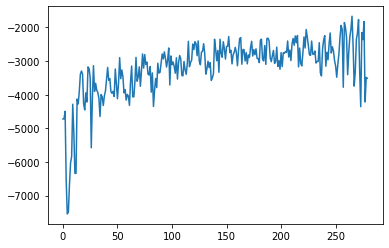

In [ ]:
plt.plot(rewards_storage[20:])

In [ ]:
main_list=data_collection_over_eps(1,env,dqn_solver,autoencoder)

In [ ]:
SARS = dqn_solver.minibatch()
        
s = dqn_solver.state_shape([row[0] for row in SARS])
s=s.reshape(BATCH_SIZE,1,state_space)
#print(s.shape)
qvalue = np.array(dqn_solver.model.Qpolicy.predict_on_batch(s))
print(qvalue)

[[[nan nan nan nan]]

 [[nan nan nan nan]]

 [[nan nan nan nan]]

 [[nan nan nan nan]]

 [[nan nan nan nan]]

 [[nan nan nan nan]]

 [[nan nan nan nan]]

 [[nan nan nan nan]]

 [[nan nan nan nan]]

 [[nan nan nan nan]]

 [[nan nan nan nan]]

 [[nan nan nan nan]]

 [[nan nan nan nan]]

 [[nan nan nan nan]]

 [[nan nan nan nan]]

 [[nan nan nan nan]]

 [[nan nan nan nan]]

 [[nan nan nan nan]]

 [[nan nan nan nan]]

 [[nan nan nan nan]]

 [[nan nan nan nan]]

 [[nan nan nan nan]]

 [[nan nan nan nan]]

 [[nan nan nan nan]]

 [[nan nan nan nan]]

 [[nan nan nan nan]]

 [[nan nan nan nan]]

 [[nan nan nan nan]]

 [[nan nan nan nan]]

 [[nan nan nan nan]]

 [[nan nan nan nan]]

 [[nan nan nan nan]]

 [[nan nan nan nan]]

 [[nan nan nan nan]]

 [[nan nan nan nan]]

 [[nan nan nan nan]]

 [[nan nan nan nan]]

 [[nan nan nan nan]]

 [[nan nan nan nan]]

 [[nan nan nan nan]]

 [[nan nan nan nan]]

 [[nan nan nan nan]]

 [[nan nan nan nan]]

 [[nan nan nan nan]]

 [[nan nan nan nan]]

 [[nan nan

In [ ]:
main_list[3][2]

[array([[0., 0., 0., 0., 0.]]),
 array([[-0.01168804,  1.3933742 ,  0.01502078,  0.        ,  0.        ]],
       dtype=float32),
 array([[-0.01748238,  1.3840904 ,  0.02318253,  0.        ,  0.        ]],
       dtype=float32),
 array([[-0.02336397,  1.3747953 ,  0.03128639,  0.        ,  0.        ]],
       dtype=float32),
 array([[-0.02915182,  1.3660154 ,  0.04026309,  0.        ,  0.        ]],
       dtype=float32),
 array([[-0.03496122,  1.3566364 ,  0.04944541,  0.        ,  0.        ]],
       dtype=float32),
 array([[-0.04079122,  1.3466587 ,  0.05883274,  0.        ,  0.        ]],
       dtype=float32),
 array([[-0.04664116,  1.3360825 ,  0.06842323,  0.        ,  0.        ]],
       dtype=float32),
 array([[-0.05251036,  1.3249075 ,  0.07821514,  0.        ,  0.        ]],
       dtype=float32),
 array([[-0.05839796,  1.3131343 ,  0.08820657,  0.        ,  0.        ]],
       dtype=float32),
 array([[-0.0645256 ,  1.3018162 ,  0.09763876,  0.        ,  0.        ]],
 

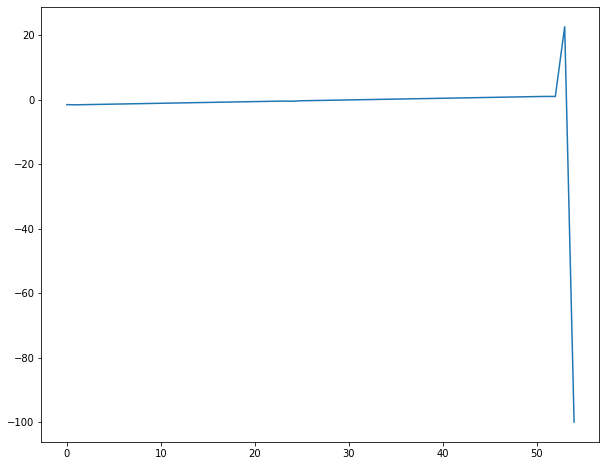

In [ ]:
plt.plot(main_list[0][3])

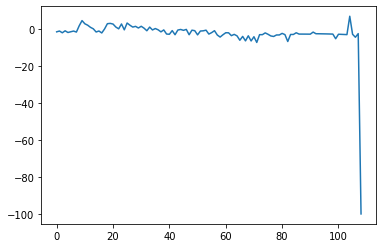

In [ ]:
plt.plot(main_list[15][3])

In [ ]:
dqn_solver.model.Qpolicy.weights

[<tf.Variable 'dense/kernel:0' shape=(8, 512) dtype=float32, numpy=
 array([[ 0.82123125,  0.42934525,  0.05096253, ...,  0.3647885 ,
          0.0994314 , -0.2683639 ],
        [-0.67937493,  0.2688619 , -0.68958133, ...,  0.2258716 ,
          0.6236033 , -0.02876558],
        [-0.11073398, -0.62565464, -0.41276196, ..., -0.43361318,
          0.283246  ,  0.65821   ],
        ...,
        [ 0.17734148,  0.8514506 , -0.07971108, ..., -0.5160497 ,
          0.7019278 , -0.7165619 ],
        [ 0.02356142, -0.9070622 , -0.879984  , ..., -0.74160004,
         -0.8347057 ,  0.5078262 ],
        [-0.03033539, -0.81130373,  0.5196361 , ..., -0.10322863,
         -0.80854267, -0.657611  ]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(512,) dtype=float32, numpy=
 array([-0.02744765,  0.06880413,  0.04134379,  0.00707401,  0.07628322,
         0.07799362,  0.00344654,  0.02634252,  0.14637017,  0.12094188,
         0.11168925, -0.0149236 ,  0.07522801,  0.0559929 ,  0.07698838,
      

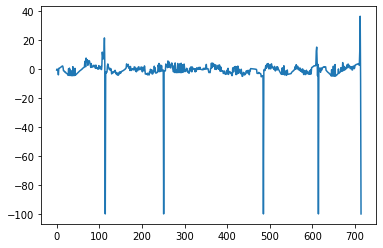

In [ ]:
plt.plot(R_series)

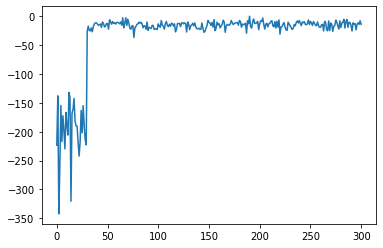

In [ ]:
plt.plot([x/80 for x in rewards_storage])

In [ ]:
final_list=[]
for i,x in enumerate(rewards_storage):
    if(i<20):
        final_list.append(x/80)
    else:
        final_list.append(x/10)

In [ ]:
plt.rcParams['figure.figsize']=[20,10]

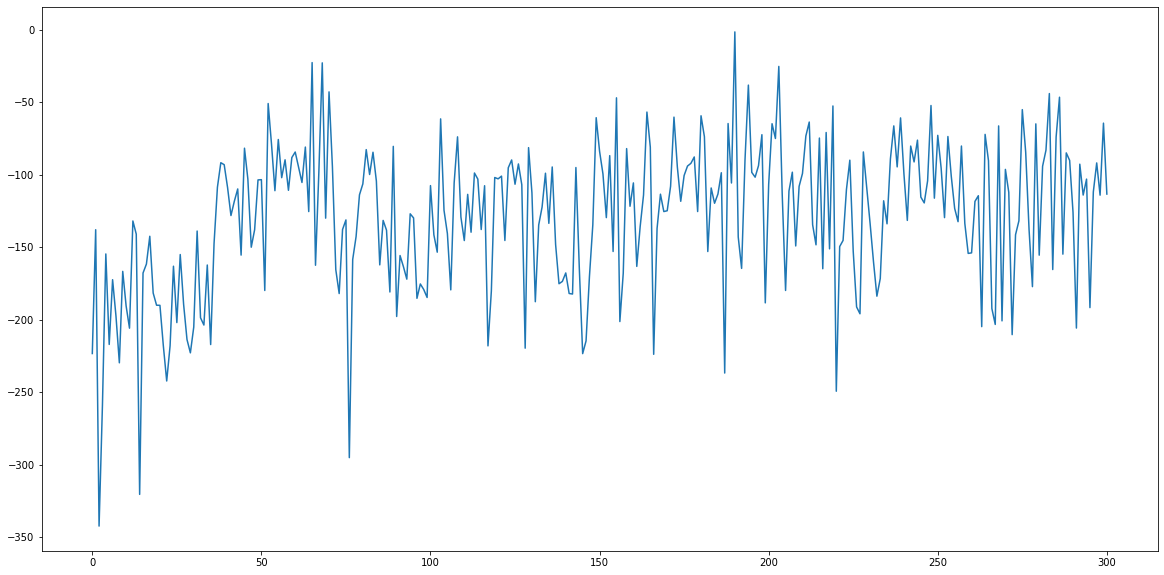

In [ ]:
plt.plot(final_list)

In [ ]:
df=pd.DataFrame(rewards_storage)
df.to_csv('rewards_final_main_lunar_4.csv')

In [ ]:
S_series,O_series,U_series,R_series,O_predicted_series,Done_series=data_collection(5,env,dqn_solver,autoencoder)


In [ ]:
U_series

[array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[3.]], dtype=float32),
 array([[2.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[2.]], dtype=float32),
 array([[2.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[2.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[2.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[2.]], dtype=float32),
 array([[2.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[2.]], dtype=float32),
 array([[2.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[2.]], dtype=float32),
 array([[2.]], dtype=float32),
 array([

In [ ]:
for i,x in enumerate(O_series):
    if(x[0][3]==1.0)or(x[0][4]==1.0):
        print(i)

294
295
422
423
424
425
426
557
558
559
560
561
562
563
564
641
642
715
716
717
718


In [ ]:
type(dqn_solver.minibatch()[0])

list

In [ ]:
dqn_solver.model.Qpolicy.weights

[<tf.Variable 'dense/kernel:0' shape=(8, 512) dtype=float32, numpy=
 array([[-0.71096325,  0.8821554 ,  0.30807063, ...,  0.5832809 ,
         -0.7258383 ,  0.5776177 ],
        [-0.55267906,  0.8131923 ,  0.7552484 , ..., -0.27463394,
         -0.8039288 , -0.15334997],
        [-0.5017143 , -0.82488257,  0.65498334, ..., -0.25931185,
          0.3388881 ,  0.2957606 ],
        ...,
        [ 0.23639064,  0.84650916,  0.8375657 , ..., -0.71045816,
         -0.60479295, -0.5183121 ],
        [ 0.6313381 ,  0.03855103,  0.458513  , ...,  0.8262256 ,
          0.07631703,  0.56319445],
        [-0.15502247,  0.56367177, -0.6232959 , ...,  0.5148971 ,
          0.06868022,  0.5208533 ]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(512,) dtype=float32, numpy=
 array([ 5.30715644e-01,  4.42305088e-01, -2.86167055e-01,  1.62351519e-01,
         1.26445815e-01,  3.73124361e-01,  5.01945056e-02,  1.20016716e-01,
         3.05543374e-02,  9.58127156e-02,  2.71259755e-01, -6.12629414e-0